# OIH Queries 

Example queries related to OIH

## Setup and inits

### Imports

In [20]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
# import dask, boto3
# import dask.dataframe as dd
import numpy as np
import json
import geopandas
import matplotlib.pyplot as plt
import shapely
# import kglab as kg

oih = "https://ts.collaborium.io/blazegraph/namespace/oih/sparql"
oihdev = "https://ts.collaborium.io/blazegraph/namespace/development/sparql"
oihinvemar = "https://ts.collaborium.io/blazegraph/namespace/invemar/sparql"
oiheurocean = "https://ts.collaborium.io/blazegraph/namespace/eurocean/sparql"
oihad = "https://graph.collaborium.io/blazegraph/namespace/aquadocs/sparql"

### Support Functions

In [21]:
#@title
def get_sparql_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

## Queries

What follows is a set of queries designed to provide a feel for the OIH graph

### Simple Count

How many triples are there?

In [22]:
rq_count = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [23]:
dfsc = get_sparql_dataframe(oiheurocean, rq_count)
dfsc.head()

Triples
0  1224284

## Simple org list  (not done)


In [24]:
rq_orgs = """SELECT (COUNT(*) as ?Triples) 
WHERE 
  {
      { ?s ?p ?o } 
  }
"""

In [25]:
dfsc = get_sparql_dataframe(oiheurocean, rq_orgs)
dfsc.head()

Triples
0  1224284

### Predicate Counts

This gives an overview of unique predicates that connect a subject to an object.  This gives us both an idea of the properties we are using on things and count of their usage.


In [26]:
rq_pcount = """SELECT ?p (COUNT(?p) as ?pCount)
WHERE
{
  ?s ?p ?o .
}
GROUP BY ?p
"""

In [27]:
dfc = get_sparql_dataframe(oiheurocean, rq_pcount)
dfc['pCount'] = dfc["pCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [28]:
dfc_sorted = dfc.sort_values('pCount', ascending=False)
dfc_sorted.head(10)

p  pCount
30  http://www.w3.org/1999/02/22-rdf-syntax-ns#type  329248
2                           https://schema.org/name   94158
0                    https://schema.org/description   75316
19                    https://schema.org/knowsAbout   72085
10                  http://www.w3.org/ns/prov#value   62026
4                            https://schema.org/url   51926
23                 https://schema.org/timezone_type   38826
22                      https://schema.org/timezone   38826
17                          https://schema.org/date   38826
28                        https://schema.org/member   36734

In [29]:
rcount = len(dfc_sorted)
print(rcount)

32


In [30]:
ts = dfc_sorted.tail(38)['pCount'].sum()
print(ts)

1224284


In [31]:
hs = dfc_sorted.head(10)
hs.append({'p':'Other','pCount':ts}, ignore_index=True) 
hs.set_index('p', inplace=True)
hs.head(10)

/tmp/ipykernel_171800/3595049396.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hs.append({'p':'Other','pCount':ts}, ignore_index=True)


pCount
p                                                      
http://www.w3.org/1999/02/22-rdf-syntax-ns#type  329248
https://schema.org/name                           94158
https://schema.org/description                    75316
https://schema.org/knowsAbout                     72085
http://www.w3.org/ns/prov#value                   62026
https://schema.org/url                            51926
https://schema.org/timezone_type                  38826
https://schema.org/timezone                       38826
https://schema.org/date                           38826
https://schema.org/member                         36734

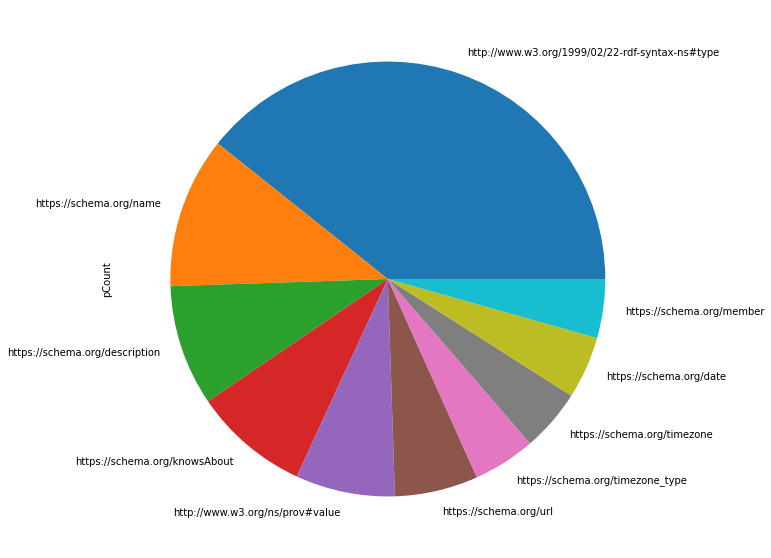

In [32]:
plot = hs.plot.pie(y='pCount',x='p',legend=False, figsize=(10, 10))

### OIH Base Query

In [33]:
rq_main = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s   ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }

        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [34]:
df = get_sparql_dataframe(oiheurocean, rq_main)
df.head(5)

g  \
0  urn:gleaner-oih:summoned:euroceanexpert:267477...   
1  urn:gleaner-oih:summoned:euroceanorgs:187638c3...   
2  urn:gleaner-oih:summoned:euroceanorgs:4e39d199...   
3  urn:gleaner-oih:summoned:euroceanorgs:805f64e9...   
4  urn:gleaner-oih:summoned:euroceanorgs:9c13b4fe...   

                                           s                             type  \
0       https://oceanexpert.org/expert/37306        https://schema.org/Person   
1  https://oceanexpert.org/institution/21023  https://schema.org/Organization   
2  https://oceanexpert.org/institution/20915  https://schema.org/Organization   
3   https://oceanexpert.org/institution/5662  https://schema.org/Organization   
4  https://oceanexpert.org/institution/22454  https://schema.org/Organization   

   score                                               name  \
0  0.625                   BOTOSOAMANANTO Radonirina Lebely   
1  0.625  Coral Triangle Initiative on Coral Reefs,  Fis...   
2  0.625                                      Restore Coral   
3    0.5                         Coral Cay Conservation Ltd   
4    0.5                          Coral Reef Advisory Group   

                                         url  \
0                       https://www.ihsm.mg/   
1    http://www.coraltriangleinitiative.org/   
2               http://www.restorecoral.org/   
3                   http://www.coralcay.org/   
4  https://oceanexpert.org/institution/22454   

                                                 lit description headline  
0                                    Coral biologist        None     None  
1  Coral Triangle Initiative on Coral Reefs,  Fis...        None     None  
2                                      Restore Coral        None     None  
3                         Coral Cay Conservation Ltd        None     None  
4                          Coral Reef Advisory Group        None     None

### OIH Gleaner Query

In [35]:
rq_maingl = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT ?g  ?s  ?wat ?orgname ?domain ?type ?score ?name ?url ?lit ?description ?headline
        WHERE
        {
           ?lit bds:search "coral" .
           ?lit bds:matchAllTerms "false" .
           ?lit bds:relevance ?score .
           graph ?g {
            ?s ?p ?lit .
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        ORDER BY DESC(?score)
        LIMIT 30
        OFFSET 0
        """

In [36]:
df = get_sparql_dataframe(oiheurocean, rq_maingl)
df.head(5)

Empty DataFrame
Columns: [g, s, wat, orgname, domain, type, score, name, url, lit, description, headline]
Index: []

## Query for prov

Count (count(distinct ?tag) as ?count) 

Need to look for the date in the prov record too.  I keep it by day granularity, so I should be able to see the difference if I focos on a specific repo or look over the dates

In [19]:
rq_prov = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?hm) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?wat ?orgname ?domain
        """

In [20]:
rq_prov2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT ( COUNT(?s) as ?count) ?wat  ?orgname ?domain
        WHERE
        {
           graph ?g {
             VALUES (?type) { ( schema:CreativeWork ) ( schema:Map )  ( schema:Person )  ( schema:Organization )  ( schema:Dataset )  ( schema:Course ) } 
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
                GROUP BY ?wat ?orgname ?domain

        """

In [21]:
dfp = get_sparql_dataframe(oihdev, rq_prov)
dfp['count'] = dfp["count"].astype(int) # convert count c to int
dfp.set_index('orgname', inplace=True)
dfp

count  \
orgname                                                 
AquaDocs                                            1   
Marine Training EU                                313   
Ocean Biodiversity Information System            4382   
Ocean Best Practices                                1   
OceanExpert UNESCO/IOC Project Office for IODE  29103   
EDMO SeaDataNet                                  4508   
EDMERP SeaDataNet                                3354   
INVEMAR documents                                   1   
INVEMAR Experts                                     1   
INVEMAR institution                                 1   
INVEMAR training                                    1   
INVEMAR vessel                                      1   

                                                                                              wat  \
orgname                                                                                             
AquaDocs                                              https://www.re3data.org/repository/aquadocs   
Marine Training EU                              https://www.re3data.org/repository/marinetraining   
Ocean Biodiversity Information System                     https://www.re3data.org/repository/obis   
Ocean Best Practices                                      https://www.re3data.org/repository/obps   
OceanExpert UNESCO/IOC Project Office for IODE     https://www.re3data.org/repository/oceanexpert   
EDMO SeaDataNet                                 https://www.re3data.org/repository/seadatanet/...   
EDMERP SeaDataNet                               https://www.re3data.org/repository/seadatanet/...   
INVEMAR documents                                            http://example.org/invemar/documents   
INVEMAR Experts                                                http://example.org/invemar/experts   
INVEMAR institution                                        http://example.org/invemar/institution   
INVEMAR training                                              http://example.org/invemar/training   
INVEMAR vessel                                                  http://example.org/invemar/vessel   

                                                                                           domain  
orgname                                                                                            
AquaDocs                                                                     https://aquadocs.org  
Marine Training EU                                                     https://marinetraining.eu/  
Ocean Biodiversity Information System                                            https://obis.org  
Ocean Best Practices                                           https://oih.oceanbestpractices.org  
OceanExpert UNESCO/IOC Project Office for IODE                           https://oceanexpert.org/  
EDMO SeaDataNet                                                       https://edmo.seadatanet.org  
EDMERP SeaDataNet                                                   https://edmerp.seadatanet.org  
INVEMAR documents                               http://portete.invemar.org.co/chm/api/oih/docu...  
INVEMAR Experts                                  http://portete.invemar.org.co/chm/api/oih/expert  
INVEMAR institution                             http://portete.invemar.org.co/chm/api/oih/inst...  
INVEMAR training                                http://portete.invemar.org.co/chm/api/oih/trai...  
INVEMAR vessel                                   http://portete.invemar.org.co/chm/api/oih/vessel

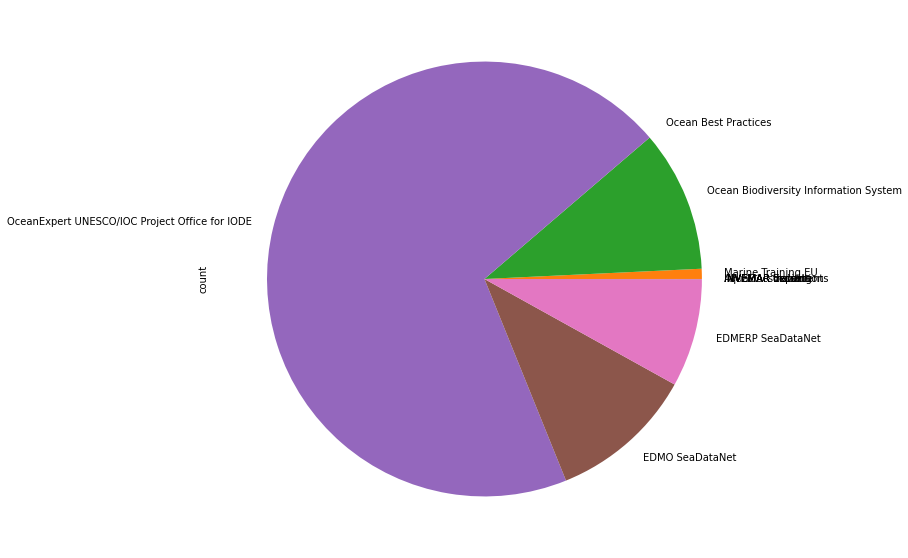

In [23]:
plot = dfp.plot.pie(y='count',legend=False, figsize=(10, 10))

In [24]:
rq_provdate = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?s) as ?count) ?time ?orgname
        WHERE
        {
           ?s a prov:Activity  .
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
           ?wat rdfs:seeAlso ?domain
        }
        GROUP BY ?time ?orgname  
        """

dfpd = get_sparql_dataframe(oihdev, rq_provdate)

In [25]:
dfpd.head(30)

count                      time  \
0     626  2021-09-25T00:00:00.000Z   
1     626  2021-10-18T00:00:00.000Z   
2     624  2021-11-23T00:00:00.000Z   
3       1  2021-09-25T00:00:00.000Z   
4       1  2021-11-28T00:00:00.000Z   
5    7527  2021-09-25T00:00:00.000Z   
6    7547  2021-10-18T00:00:00.000Z   
7    6659  2021-11-23T00:00:00.000Z   
8   13641  2021-10-18T00:00:00.000Z   
9    7074  2021-11-23T00:00:00.000Z   
10  56902  2021-09-25T00:00:00.000Z   
11  43586  2021-10-19T00:00:00.000Z   
12      1  2021-09-25T00:00:00.000Z   
13      1  2021-11-28T00:00:00.000Z   
14   4508  2021-12-18T00:00:00.000Z   
15   3354  2021-12-18T00:00:00.000Z   
16      1  2022-01-04T00:00:00.000Z   
17      1  2022-01-04T00:00:00.000Z   
18      1  2022-01-04T00:00:00.000Z   
19      1  2022-01-04T00:00:00.000Z   
20      1  2022-01-04T00:00:00.000Z   

                                           orgname  
0                               Marine Training EU  
1                               Marine Training EU  
2                               Marine Training EU  
3                                         AquaDocs  
4                                         AquaDocs  
5            Ocean Biodiversity Information System  
6            Ocean Biodiversity Information System  
7            Ocean Biodiversity Information System  
8   OceanExpert UNESCO/IOC Project Office for IODE  
9   OceanExpert UNESCO/IOC Project Office for IODE  
10  OceanExpert UNESCO/IOC Project Office for IODE  
11  OceanExpert UNESCO/IOC Project Office for IODE  
12                            Ocean Best Practices  
13                            Ocean Best Practices  
14                                 EDMO SeaDataNet  
15                               EDMERP SeaDataNet  
16                               INVEMAR documents  
17                                 INVEMAR Experts  
18                             INVEMAR institution  
19                                INVEMAR training  
20                                  INVEMAR vessel

In [26]:
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   count    21 non-null     object
 1   time     21 non-null     object
 2   orgname  21 non-null     object
dtypes: object(3)
memory usage: 632.0+ bytes


In [27]:
# dfpd = get_sparql_dataframe(oihdev, rq_provdate)
dfpd['count'] = dfpd["count"].astype(int) # convert count c to int
dfpd['time'] = pd.to_datetime(dfpd['time'])
dftime = dfpd.sort_values(by='time') 
# dfpd['time'] = dfpd['time'].astype('datetime64[ns]')
# dfpd.set_index('time', inplace=True)


In [28]:
dftime.set_index('time', inplace=True)

dftime.head(20)


count  \
time                               
2021-09-25 00:00:00+00:00    626   
2021-09-25 00:00:00+00:00      1   
2021-09-25 00:00:00+00:00   7527   
2021-09-25 00:00:00+00:00  56902   
2021-09-25 00:00:00+00:00      1   
2021-10-18 00:00:00+00:00    626   
2021-10-18 00:00:00+00:00   7547   
2021-10-18 00:00:00+00:00  13641   
2021-10-19 00:00:00+00:00  43586   
2021-11-23 00:00:00+00:00    624   
2021-11-23 00:00:00+00:00   6659   
2021-11-23 00:00:00+00:00   7074   
2021-11-28 00:00:00+00:00      1   
2021-11-28 00:00:00+00:00      1   
2021-12-18 00:00:00+00:00   4508   
2021-12-18 00:00:00+00:00   3354   
2022-01-04 00:00:00+00:00      1   
2022-01-04 00:00:00+00:00      1   
2022-01-04 00:00:00+00:00      1   
2022-01-04 00:00:00+00:00      1   

                                                                  orgname  
time                                                                       
2021-09-25 00:00:00+00:00                              Marine Training EU  
2021-09-25 00:00:00+00:00                            Ocean Best Practices  
2021-09-25 00:00:00+00:00           Ocean Biodiversity Information System  
2021-09-25 00:00:00+00:00  OceanExpert UNESCO/IOC Project Office for IODE  
2021-09-25 00:00:00+00:00                                        AquaDocs  
2021-10-18 00:00:00+00:00                              Marine Training EU  
2021-10-18 00:00:00+00:00           Ocean Biodiversity Information System  
2021-10-18 00:00:00+00:00  OceanExpert UNESCO/IOC Project Office for IODE  
2021-10-19 00:00:00+00:00  OceanExpert UNESCO/IOC Project Office for IODE  
2021-11-23 00:00:00+00:00                              Marine Training EU  
2021-11-23 00:00:00+00:00           Ocean Biodiversity Information System  
2021-11-23 00:00:00+00:00  OceanExpert UNESCO/IOC Project Office for IODE  
2021-11-28 00:00:00+00:00                            Ocean Best Practices  
2021-11-28 00:00:00+00:00                                        AquaDocs  
2021-12-18 00:00:00+00:00                                 EDMO SeaDataNet  
2021-12-18 00:00:00+00:00                               EDMERP SeaDataNet  
2022-01-04 00:00:00+00:00                               INVEMAR documents  
2022-01-04 00:00:00+00:00                                 INVEMAR Experts  
2022-01-04 00:00:00+00:00                             INVEMAR institution  
2022-01-04 00:00:00+00:00                                INVEMAR training

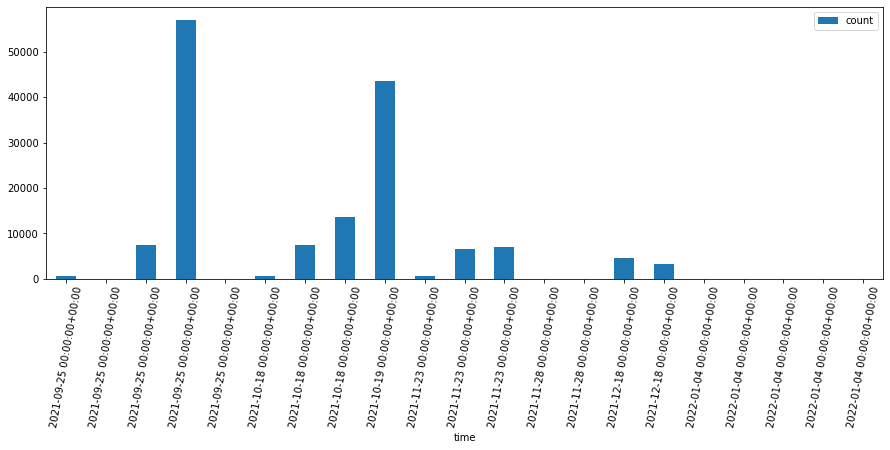

In [29]:
ax = dftime.plot.bar(rot=80, stacked=True, figsize=(15, 5))

## Feed query

Goal here is see if the prov will give us the elements for an RSS feed.  
The [RSS specs](https://validator.w3.org/feed/docs/rss2.html) give us the elements we need to populate.  Focus on; title(name), date, author, description

A recent example from gov at https://www.govinfo.gov/feeds

Since this could be very large injest, do it by the ingest events above instead?

* Element 	Description 	Example
* title 	The title of the item. 	Venice Film Festival Tries to Quit Sinking
* link 	The URL of the item. 	http://www.nytimes.com/2002/09/07/movies/07FEST.html
* description 	The item synopsis. 	Some of the most heated chatter at the Venice Film Festival this week was about the way that the arrival of the stars at the Palazzo del Cinema was being staged.
* author 	Email address of the author of the item. More. 	oprah@oxygen.net
* category 	Includes the item in one or more categories. More. 	Simpsons Characters
* comments 	URL of a page for comments relating to the item. More. 	http://www.myblog.org/cgi-local/mt/mt-comments.cgi?entry_id=290
* enclosure 	Describes a media object that is attached to the item. More. 	<enclosure url="http://live.curry.com/mp3/celebritySCms.mp3" length="1069871" type="audio/mpeg"/>
* guid 	A string that uniquely identifies the item. More. 	<guid isPermaLink="true">http://inessential.com/2002/09/01.php#a2</guid>
* pubDate 	Indicates when the item was published. More. 	Sun, 19 May 2002 15:21:36 GMT
* source 	The RSS channel that the item came from. More. 	<source url="http://www.quotationspage.com/data/qotd.rss">Quotes of the Day</source>

In [30]:
rq_provdatelist = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT  ?time ?orgname ?memval  ?memname ?memdesc
        WHERE
        {
           ?s prov:endedAtTime ?time .
           ?s prov:generated ?gen .
           ?s prov:used ?used .
           ?used prov:hadMember ?mem .
           ?mem prov:value ?memval .
           ?mem schema:name ?memname .
           ?mem schema:description ?memdesc .
           ?mem prov:wasAttributedTo ?wat .
           ?wat rdf:name ?orgname .
        }
        ORDER BY DESC(?time) ASC(?memname)
        LIMIT 1000

        """

         #            ?s a prov:Activity  .

         #   ?wat rdfs:seeAlso ?domain

In [31]:
%%time
dfpl = get_sparql_dataframe(oihdev, rq_provdatelist)
dfpl.head(10)

CPU times: user 18.6 ms, sys: 7.5 ms, total: 26.1 ms
Wall time: 9.14 s


time            orgname  \
0  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
1  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
2  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
3  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
4  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
5  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
6  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
7  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   
8  2021-12-18T00:00:00.000Z    EDMO SeaDataNet   
9  2021-12-18T00:00:00.000Z  EDMERP SeaDataNet   

                                       memval  \
0  https://edmerp.seadatanet.org/report/11405   
1  https://edmerp.seadatanet.org/report/11406   
2  https://edmerp.seadatanet.org/report/11410   
3  https://edmerp.seadatanet.org/report/11407   
4  https://edmerp.seadatanet.org/report/11414   
5  https://edmerp.seadatanet.org/report/11408   
6  https://edmerp.seadatanet.org/report/11415   
7  https://edmerp.seadatanet.org/report/11273   
8     https://edmo.seadatanet.org/report/4141   
9  https://edmerp.seadatanet.org/report/10405   

                                             memname  \
0                                      'Akvanavt-98'   
1                                   'Akvanavt-98-RF'   
2                                    'Akvanavt-99-m'   
3                                           'Djubga'   
4  'Integrated optical-hydro-lithodynamics  inves...   
5                                        'Neftyanik'   
6                                'Turbidimetr -2000'   
7  (CIPS/ICWB) SEA - an extensive multidisciplina...   
8       (Inland Fisheries Ireland) Cullion Fish Farm   
9  18 EXPEDITION 'ASSESSMENT OF CONTAMINATION OF ...   

                                             memdesc  
0  Study of the hydro-physical characteristics of...  
1  Study of the hydrologic structure in Russian s...  
2  Method preparation and experimental works on s...  
3  Study of the seismic and seismic-acoustic bott...  
4  Integrated optical-hydro-lithodynamics investi...  
5  Carrying out of the hydrographical survey by t...  
6  Research, development and making of the suspen...  
7  ï¿½Project Sea" was the first major programme ...  
8  Inland Fisheries Ireland trout fish farm opera...  
9  Aims of the expedition included also carrying ...

## Keywords

In [32]:
rq_keywords = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

       SELECT   ( COUNT(?kw) as ?count) ?kw   
        WHERE
        {
           ?s schema:keywords ?kw
        }
        GROUP BY ?kw  
        ORDER BY DESC(?count)
        """


In [33]:
dfkw = get_sparql_dataframe(oihdev, rq_keywords)
dfkw['count'] = dfkw["count"].astype(int) # convert count c to int
dfkw.set_index('kw', inplace=True)
dfkw.head(10)

count
kw                
Fisheries    43873
Biology      20834
Aquaculture  11790
Ecology      10524
GCFI          8856
Iran          8382
Management    7809
Occurrence    6825
Observation   5317
Limnology     5025

In [34]:
dfkw.to_csv('keywords.csv', index=False)

## Types Breakdown


In [35]:
rq_types = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?type) as ?count) ?type   
        WHERE
        {
        
           ?s rdf:type ?type
           FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization, schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course, schema:CourseInstance, schema:Event, schema:Vehicle) )

        }
        GROUP BY ?type  
        ORDER BY DESC(?count)
        """




In [36]:
dft = get_sparql_dataframe(oihdev, rq_types)
dft['count'] = dft["count"].astype(int) # convert count c to int
dft.set_index('type', inplace=True)
dft.head(10)

count
type                                      
https://schema.org/Person           345127
https://schema.org/Organization      87007
https://schema.org/CreativeWork      41058
https://schema.org/Event             40393
https://schema.org/Dataset            8509
https://schema.org/ResearchProject    3354
https://schema.org/CourseInstance     1651
https://schema.org/Course             1282
https://schema.org/Vehicle              85

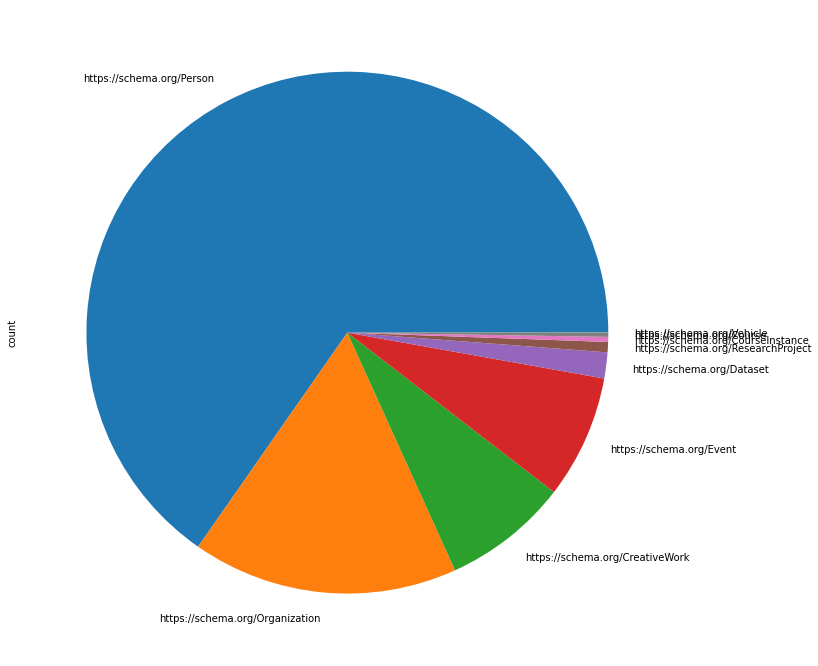

In [37]:
plot_t = dft.plot.pie(y='count',legend=False, figsize=(12, 12))

In [38]:
rq_typesCHECK = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT  ( COUNT(?type) as ?count) ?type   
        WHERE
         {
           graph ?g {
            
            ?s rdf:type ?type . 
            OPTIONAL { ?s schema:name ?name .   }
            OPTIONAL { ?s schema:headline ?headline .   }
            OPTIONAL { ?s schema:url ?url .   }
            OPTIONAL { ?s schema:description ?description .    }
          }
           ?sp prov:generated ?g  .
           ?sp prov:used ?used .
           ?used prov:hadMember ?hm .
           ?hm prov:wasAttributedTo ?wat .
          
        }
        GROUP BY ?type  
         ORDER BY DESC(?count)
   
        """

#      GROUP BY ?type  
#         ORDER BY DESC(?count)

#  ( COUNT(?type) as ?count) ?type  

# ?s ?p ?lit .

#  ?wat rdf:name "Ocean Biodiversity Information System" .

In [39]:
dft = get_sparql_dataframe(oihdev, rq_typesCHECK)
# dft['count'] = dft["count"].astype(int) # convert count c to int
# dft.set_index('type', inplace=True)
dft.head(20)

count                                  type
0   289746             https://schema.org/Person
1   145419               https://schema.org/Text
2    91390      https://schema.org/PropertyValue
3    81390       https://schema.org/CreativeWork
4    81386           https://schema.org/ListItem
5    76040       https://schema.org/Organization
6    40427              https://schema.org/Event
7    27696            https://schema.org/Country
8    18783      https://schema.org/PostalAddress
9    17796              https://schema.org/Place
10    8509            https://schema.org/Dataset
11    8509        https://schema.org/DataCatalog
12    8289       https://schema.org/DataDownload
13    7862  https://schema.org/ProgramMembership
14    7363           https://schema.org/GeoShape
15    3797       https://schema.org/ContactPoint
16    3354    https://schema.org/ResearchProject
17    1661     https://schema.org/CourseInstance
18    1651             https://schema.org/Course
19       4           https://schema.org/ItemList

## Check status of spatial predicates

We have 3500+ items with spatial data using the scheme.org vocabulary.   No current data published using the geosparql WKT patterns.  

In [40]:
rq_wktcount = """SELECT (COUNT(?s) as ?sCount)
WHERE
{
  {
  ?s <http://www.opengis.net/ont/geosparql#hasGeometry> ?o .
}
UNION
{
  ?s <https://schema.org/spatialCoverage> ?o
  }
}
"""

In [41]:
dfwc = get_sparql_dataframe(oihdev, rq_wktcount)
dfwc['sCount'] = dfwc["sCount"].astype(int) # convert count to int
# dfc.set_index('p', inplace=True)

In [42]:
dfwc.head()

sCount
0    7363

In [43]:
rq_dups = """
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT   ( COUNT(?name) as ?count) ?name   
        WHERE
        {
          ?s rdf:type ?type
           FILTER ( ?type IN ( schema:Dataset, schema:CreativeWork) )
           ?s schema:name ?name

        }
        GROUP BY ?name  
        HAVING (?count > 1)
        ORDER BY DESC(?count)
        """


dfdp = get_sparql_dataframe(oihdev, rq_dups)
dfdp['count'] = dfdp["count"].astype(int) # convert count c to int
dfdp.set_index('name', inplace=True)
dfdp.info()
dfdp.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 6551 entries,  to DistribuciÃ³n y abundancia de larvas de crustÃ¡ceos decÃ¡podos en la regiÃ³n prÃ³xima a la penÃ­nsula de Valdez (Provincia de Chubut, Argentina), durante la primavera y el verano de los aÃ±os 1978 y 1979 : relaciÃ³n de las mismas con algunas variables ambientales y biolÃ³gicas.
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   6551 non-null   int64
dtypes: int64(1)
memory usage: 102.4+ KB


count
name                                                     
                                                      381
News from Academy Bay                                  22
Roundup: news, events, briefings and more              10
Introduction                                            9
Determination of effective parameters on growth...      5
Discussion, biological session                          5
Effects of aflatoxin B1 on growth performance, ...      4
Isolation, identification and phylogenetic anal...      4
Study of possibilities of aquaculture activitie...      4
Coastal Hydrographic and Meteorological Study           4

In [44]:
qex1 = """PREFIX prov: <http://www.w3.org/ns/prov#> .
PREFIX con: <http://www.ontotext.com/connectors/lucene#> .
PREFIX luc: <http://www.ontotext.com/owlim/lucene#> .
PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#> .
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
PREFIX schema: <https://schema.org/> .
PREFIX schemaold: <http://schema.org/> .
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

SELECT DISTINCT ?s  ?name  
WHERE
        {
           ?lit bds:search "A General formatting system for geo-referenced data" .
           ?lit bds:matchAllTerms "false" .

           graph ?g {
            ?s ?p ?lit .
            FILTER isIRI(?s)
             OPTIONAL { ?s schema:name ?name .   }
           }
        }
GROUP BY    ?name ?s
LIMIT 300
OFFSET 0
"""

## OIH Query "lens"

Exploring how sites like http://portete.invemar.org.co/chm#/table could leverage OIH. Searches like "acidification"  A popular return for that search is https://aquadocs.org/handle/1834/9819 which is found in the OIH graph via [this search](https://oceans.collaborium.io/?search=Optimizaci%C3%B3n+de+los+procesos+de+ensilado+a+partir+de+residuos+de+la+industria+pesquera+y+evaluaci%C3%B3n+de+nuevas+aplicaciones+en+la+alimentaci%C3%B3n+animal.).

The thought is what would a search site do via the OIH graph that might be interesting.  We can think about looking for the types associated with a result and then seeing what the next level result would be.   



In [45]:
lens1 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?t ?ttype ?name
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
           ?s ?pp ?t .
           ?t a ?ttype .
           ?t schema:name ?name
  
  }
  """

dflens1 = get_sparql_dataframe(oihdev, lens1)
dflens1.head(10)

t                            ttype  \
0  t231465  https://schema.org/Organization   
1  t366674        https://schema.org/Person   

                                                name  
0  Universidad Nacional del Comahue. Centro Regio...  
1                               GÃ³ngora, HernÃ¡n G.

In [46]:
lens2 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

        SELECT DISTINCT  ?us ?up ?ao ?uus ?uup
        WHERE

        {
           ?s ?p "https://www.oceandocs.org/handle/1834/9819" .
              ?s <https://schema.org/author> ?auth .
              ?auth <https://schema.org/name> ?ao .
 
              ?us ?up ?ao .
              ?uus ?uo ?us
  
  }
  """

dflens1 = get_sparql_dataframe(oihdev, lens2)
dflens1.head(10)

us                       up                    ao  \
0  t366674  https://schema.org/name  GÃ³ngora, HernÃ¡n G.   

                          uus   uup  
0  oai:aquadocs.org:1834/9819  None

In [47]:
lens3 = """prefix prov: <http://www.w3.org/ns/prov#>
        PREFIX con: <http://www.ontotext.com/connectors/lucene#>
        PREFIX luc: <http://www.ontotext.com/owlim/lucene#>
        PREFIX con-inst: <http://www.ontotext.com/connectors/lucene/instance#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX schema: <https://schema.org/>
        PREFIX schemaold: <http://schema.org/>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

 
       SELECT ?itemp ?itemo
        WHERE
        {
        
           ?s rdf:type 	<https://schema.org/Vehicle> .
            ?s 	<https://schema.org/itemListElement> ?le .
                ?le ?lep ?item .
           ?item ?itemp ?itemo
        }
 
  """

dflens1 = get_sparql_dataframe(oihinvemar, lens3)
dflens1.head(10)

itemp  \
0                          https://schema.org/name   
1                          https://schema.org/name   
2                           https://schema.org/url   
3                   https://schema.org/description   
4                   https://schema.org/description   
5                      https://schema.org/category   
6          https://schema.org/vehicleConfiguration   
7          https://schema.org/vehicleConfiguration   
8           https://schema.org/vehicleSpecialUsage   
9  http://www.w3.org/1999/02/22-rdf-syntax-ns#type   

                                               itemo  
0                                  H36��Nhoc��Taurus  
1                                  H36Â NhocÂ Taurus  
2                                                     
3  Es un navio hidroceanogrÃ¡fico el cual  tiene ...  
4  Es un navio hidroceanogr��fico el cual  tiene ...  
5                                            Oceanic  
6  Sensores Decca Navigation radar TM 1226 sondas...  
7  Sensores Decca Navigation radar TM 1226 sondas...  
8                                       Oceanography  
9                         https://schema.org/Vehicle